In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
! pip install cesium
! pip install xgboost
import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

#from cesium import datasets
#from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
print(cesium.__version__)
print(xgb.__version__)
print(scipy.__version__)
print(sklearn.__version__)

0.12.1
2.0.2
1.11.4
1.0.2


## Классификация временных рядов
Рассматривается пример представления признаками необработанных временных рядов данных электроэнцефалограммы (ЭЭГ), которые в дальнейшем подвергаются обработке с помощью алгоритмов машинного обучения.


In [5]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()


Loaded data from cached archive.


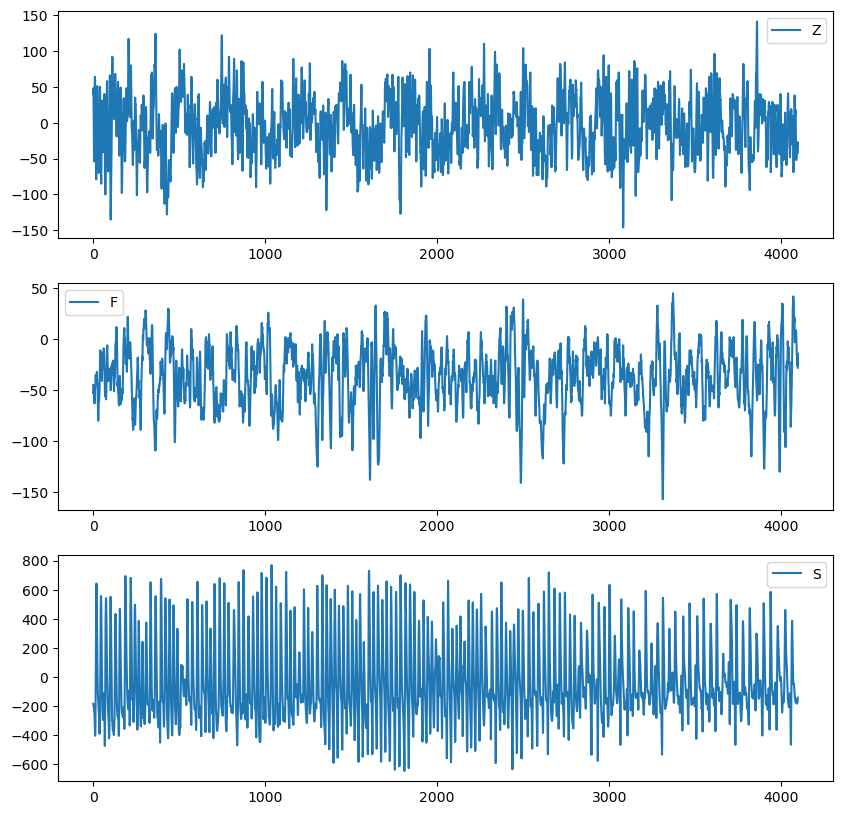

In [6]:
plt.subplot(3, 1, 1)
plt.plot(eeg[ "measurements"][0])
plt.legend(eeg['classes' ][0])
##Z
plt.subplot(3, 1, 2)
plt.plot (eeg['measurements'][300])
plt.legend(eeg['classes' ][300] )
##F
plt.subplot (3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes' ][450])
##S


## Сгенерируем признаки с помощью пакета cesium.

In [48]:
from cesium.featurize import featurize_time_series as ft
features_to_use = ["amplitude","percent_close_to_median","skew","max_slope"]
fset_cesium = ft(times = eeg["times"],values = eeg["measurements"],errors = None,features_to_use = features_to_use,scheduler = None)


Проверка сгенерированного признака

In [9]:
np.std(eeg["measurements"][0])


40.41100040099819

In [10]:
np.mean(eeg["measurements"][0])

-4.1320478398828415

In [11]:
sample_ts = eeg["measurements"][0]
sz = len(sample_ts)
ll = -4.13 - 40.4
ul = -4.13 + 40.4
quals = [i for i in range(sz) if sample_ts[i] < ll or sample_ts[i] > ul]
len(quals)/sz

0.3273126678057115

In [12]:
fset_cesium = pd.read_csv("full_eeg_data_features.csv", header = [0, 1])

In [13]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


In [14]:
fset_cesium.shape

(500, 6)

In [15]:
ex = eeg["measurements"][0]

In [16]:
ex_mean = np.mean(ex)
ex_std  = np.std(ex)

In [17]:
# amplitude
(np.max(ex) - np.min(ex)) / 2

143.5

In [18]:
 
siz = len(ex)
ll = ex_mean - ex_std
ul = ex_mean + ex_std

quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

In [19]:
# percent_close_to_median
# Percentage of values within window_frac*(max(x)-min(x)) of median.
# find the source code here:
# https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
# window frac = 0.1
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

0.03280499636078603


(array([  10.,   57.,  276.,  730., 1048., 1042.,  621.,  263.,   42.,
           8.]),
 array([-146. , -117.3,  -88.6,  -59.9,  -31.2,   -2.5,   26.2,   54.9,
          83.6,  112.3,  141. ]),
 <BarContainer object of 10 artists>)

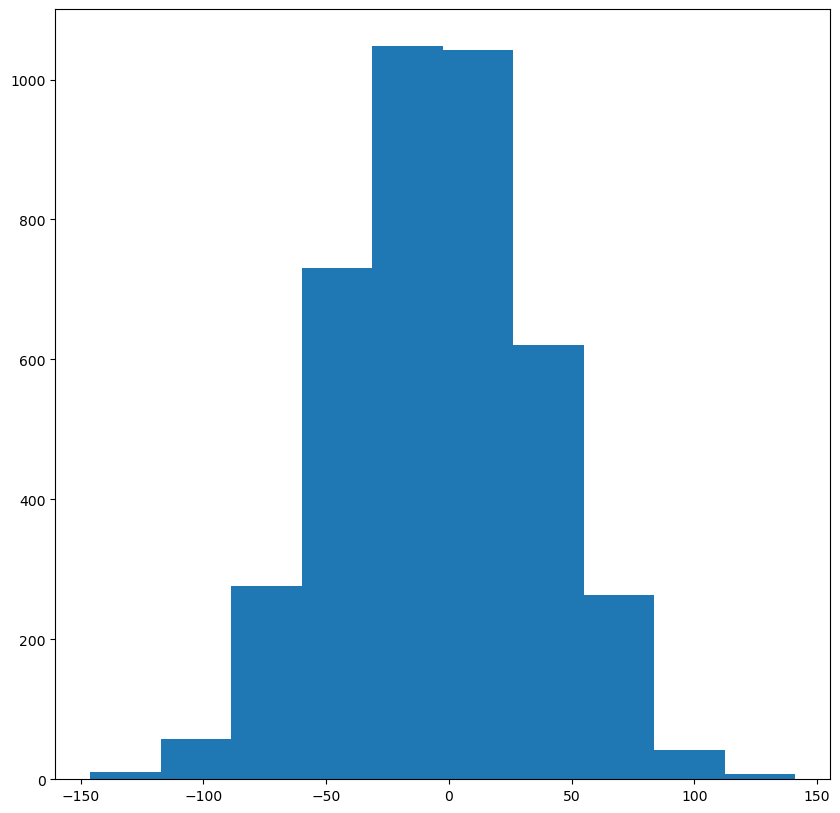

In [20]:
## skew
print(skew(ex))
plt.hist(ex)

In [21]:
## max slope
## again check definition : https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
times = eeg["times"][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

## Подготовка выборки

In [49]:
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values,
      eeg["classes"], train_size=0.67, random_state=21)

## Try a random forest with these features

In [23]:
clf = RandomForestClassifier(n_estimators=10, max_depth=3,
                              random_state=21)

In [24]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [25]:
clf.score(X_train, y_train)

0.9432835820895522

In [26]:
clf.score(X_test, y_test)

0.9575757575757575

In [27]:
np.unique(y_test, return_counts=True)

(array(['F', 'N', 'O', 'S', 'Z'], dtype='<U1'),
 array([28, 36, 33, 31, 37], dtype=int64))

In [28]:
y_test

array(['O', 'S', 'N', 'F', 'S', 'S', 'Z', 'S', 'O', 'Z', 'F', 'O', 'S',
       'F', 'Z', 'N', 'Z', 'O', 'Z', 'Z', 'S', 'F', 'O', 'N', 'F', 'F',
       'Z', 'N', 'Z', 'N', 'S', 'Z', 'O', 'O', 'S', 'S', 'N', 'S', 'N',
       'S', 'N', 'O', 'N', 'S', 'Z', 'N', 'O', 'Z', 'Z', 'S', 'O', 'Z',
       'F', 'F', 'S', 'Z', 'N', 'O', 'N', 'F', 'Z', 'Z', 'N', 'Z', 'F',
       'Z', 'N', 'F', 'O', 'N', 'N', 'Z', 'N', 'O', 'N', 'F', 'O', 'F',
       'F', 'Z', 'S', 'N', 'Z', 'N', 'O', 'N', 'S', 'N', 'S', 'O', 'O',
       'S', 'O', 'N', 'N', 'S', 'N', 'S', 'Z', 'Z', 'S', 'S', 'O', 'F',
       'S', 'F', 'F', 'Z', 'F', 'Z', 'O', 'O', 'S', 'Z', 'Z', 'F', 'N',
       'Z', 'Z', 'F', 'S', 'N', 'Z', 'N', 'N', 'S', 'N', 'O', 'F', 'F',
       'Z', 'N', 'Z', 'O', 'O', 'O', 'O', 'N', 'F', 'N', 'O', 'S', 'F',
       'Z', 'S', 'O', 'S', 'F', 'O', 'N', 'Z', 'O', 'S', 'N', 'Z', 'O',
       'N', 'F', 'F', 'S', 'Z', 'F', 'O', 'Z', 'O'], dtype='<U1')

In [29]:
y_test.shape

(165,)

In [30]:
y_train.shape

(335,)

## Try XGBoost with these features

In [42]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_encoded = label_encoder.transform(y_train)
y_encoded 

array([3, 4, 2, 4, 1, 3, 4, 2, 1, 0, 2, 4, 2, 3, 2, 2, 2, 2, 3, 0, 2, 3,
       0, 0, 3, 4, 1, 4, 0, 3, 0, 3, 3, 3, 4, 4, 2, 0, 3, 4, 2, 4, 2, 4,
       1, 0, 4, 4, 4, 0, 0, 4, 0, 0, 2, 2, 2, 2, 1, 2, 3, 0, 4, 1, 0, 2,
       2, 0, 1, 2, 0, 1, 0, 0, 3, 3, 3, 1, 0, 3, 2, 3, 2, 0, 0, 0, 0, 2,
       3, 3, 3, 3, 0, 4, 1, 2, 2, 4, 4, 4, 4, 2, 1, 4, 4, 4, 1, 1, 0, 4,
       2, 2, 4, 3, 2, 1, 2, 4, 4, 0, 4, 1, 4, 0, 4, 4, 1, 1, 3, 0, 3, 2,
       0, 0, 2, 2, 3, 1, 0, 2, 0, 3, 3, 3, 2, 2, 3, 1, 2, 1, 3, 3, 4, 1,
       1, 3, 3, 1, 2, 3, 0, 0, 3, 1, 1, 3, 3, 3, 4, 0, 0, 0, 2, 3, 4, 4,
       4, 0, 3, 4, 0, 4, 3, 3, 1, 2, 3, 3, 1, 1, 2, 0, 4, 4, 4, 3, 1, 4,
       2, 3, 2, 3, 0, 1, 0, 1, 3, 4, 0, 3, 4, 0, 4, 0, 0, 1, 0, 0, 2, 1,
       4, 3, 2, 4, 0, 0, 4, 1, 2, 0, 0, 3, 3, 2, 2, 0, 1, 1, 1, 4, 2, 4,
       0, 1, 1, 2, 4, 2, 2, 1, 1, 2, 4, 4, 4, 4, 2, 0, 2, 3, 3, 4, 2, 2,
       3, 1, 1, 3, 3, 1, 3, 1, 0, 0, 2, 1, 0, 3, 0, 0, 2, 4, 0, 0, 1, 0,
       1, 1, 3, 1, 3, 1, 4, 1, 0, 3, 1, 3, 4, 3, 1,

In [51]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                              random_state=21)


model.fit(X_train,y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [53]:
model.score(X_train, y_encoded)

0.7791044776119403

## Time Series Forecasting with Decision Trees

In [75]:
ap = pd.read_csv("AirPassengers.csv", parse_dates=[0])

In [76]:
ap.head()

,1949-01,112
0,1949-02-01,118
1,1949-03-01,132
2,1949-04-01,129
3,1949-05-01,121
4,1949-06-01,135


In [77]:
ap.columns = ['month', 'value']

In [78]:
ap.set_index('month', inplace = True)

In [79]:
ap.head()

,value
month,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135


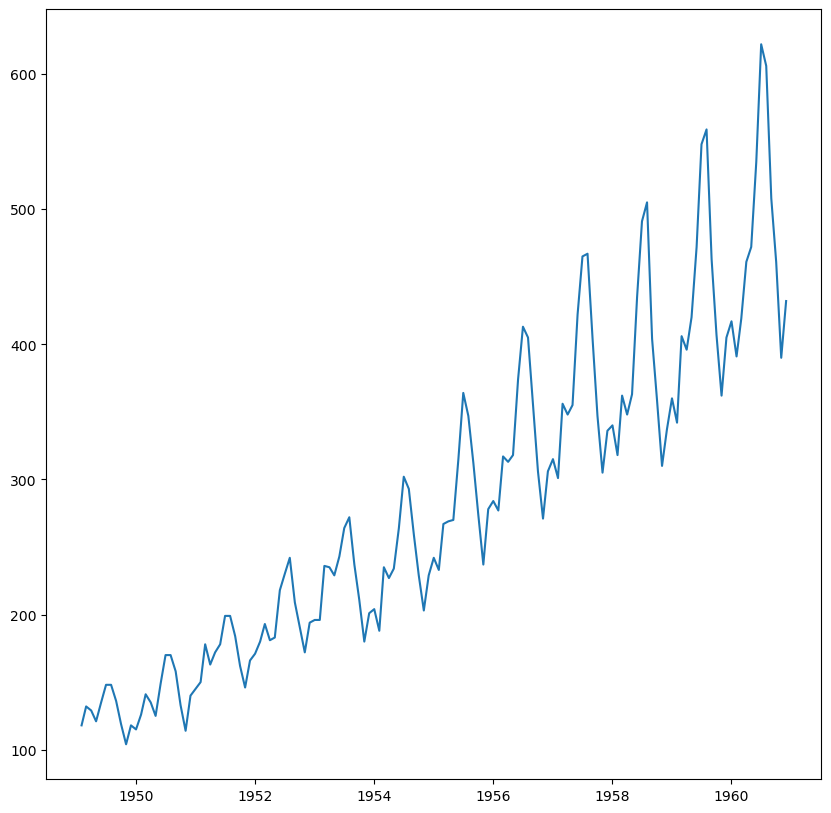

In [80]:
plt.plot(ap)

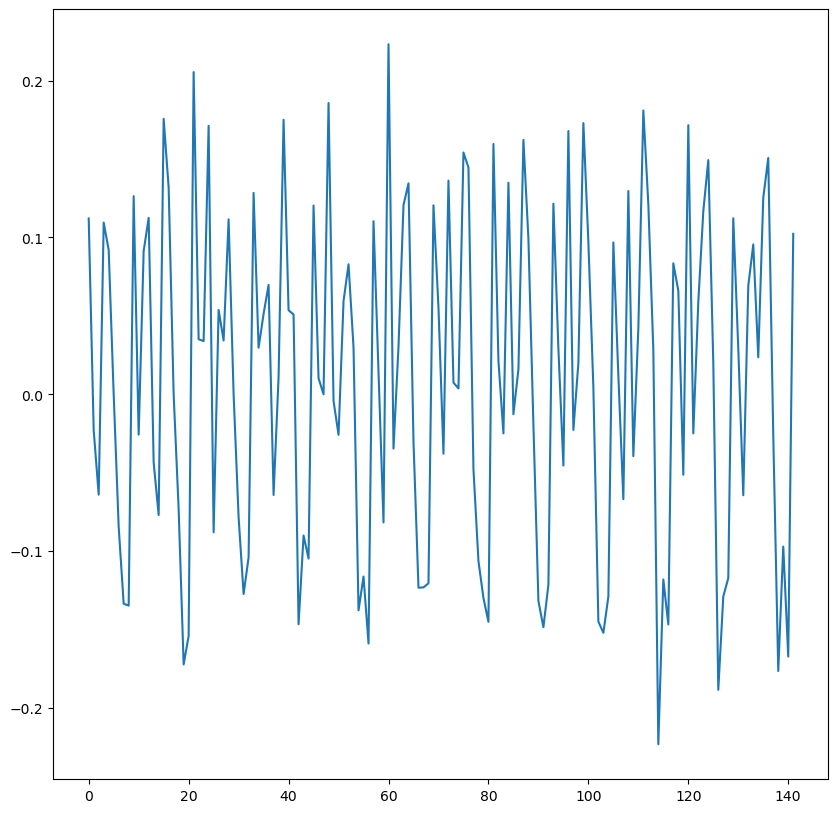

In [81]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

In [82]:
ts = np.diff(np.log(ap.values[:, 0]))

## Нам нужно найти способ генерировать объекты, которые кодируют позиционную информацию

### Сейчас сгенерируем собственные features

In [92]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [93]:
feats[0:3]

array([[ 9.        ,  8.        ,  1.        ,  0.12629372,  0.11710228,
        -0.03494394],
       [ 8.        ,  7.        ,  1.        ,  0.11247798,  0.0211282 ,
         0.13823047],
       [ 7.        ,  6.        ,  1.        ,  0.11247798, -0.1559631 ,
        -0.13483489]], dtype=float32)

### Сравним вид features

In [94]:
pd.DataFrame(feats[0:3])

,0,1,2,3,4,5
0,9.0,8.0,1.0,0.126294,0.117102,-0.034944
1,8.0,7.0,1.0,0.112478,0.021128,0.138230
2,7.0,6.0,1.0,0.112478,-0.155963,-0.134835


In [95]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [96]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.10371
[1]	validation_0-rmse:0.09751
[2]	validation_0-rmse:0.09451
[3]	validation_0-rmse:0.09097
[4]	validation_0-rmse:0.08793
[5]	validation_0-rmse:0.08134
[6]	validation_0-rmse:0.07893
[7]	validation_0-rmse:0.07472
[8]	validation_0-rmse:0.07306
[9]	validation_0-rmse:0.07019
[10]	validation_0-rmse:0.06908
[11]	validation_0-rmse:0.06766
[12]	validation_0-rmse:0.06698
[13]	validation_0-rmse:0.06589
[14]	validation_0-rmse:0.06484
[15]	validation_0-rmse:0.06394
[16]	validation_0-rmse:0.06364
[17]	validation_0-rmse:0.06269
[18]	validation_0-rmse:0.06215
[19]	validation_0-rmse:0.06185


D:\anaconda\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

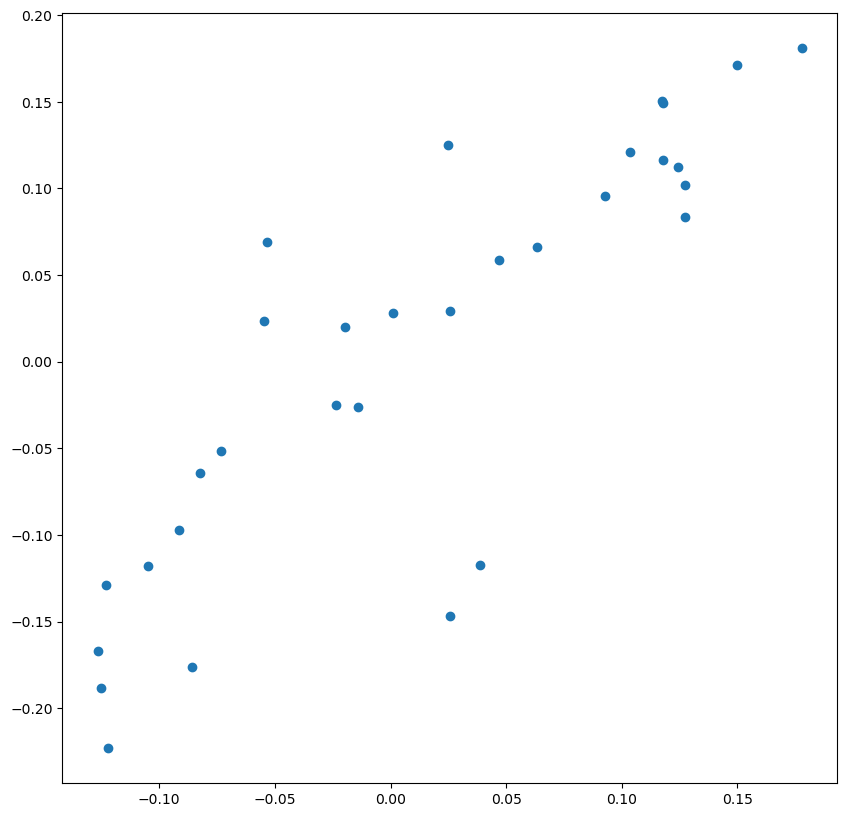

In [97]:
plt.scatter(model.predict(X_test), y_test)

In [98]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

PearsonRResult(statistic=0.8556282027266563, pvalue=8.616543669915444e-10)
SpearmanrResult(correlation=0.8523896120071992, pvalue=1.1629013187748e-09)


In [ ]:
plt.scatter(model.predict(X_train), y_train)

In [100]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))

PearsonRResult(statistic=0.9877637988205377, pvalue=6.683681463942813e-81)
SpearmanrResult(correlation=0.9830641776191977, pvalue=4.937378308943359e-74)


## Кластеризация

In [ ]:
! pip install dtaidistance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd
import numpy as np
import pdb


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score

from dtaidistance import dtw

from collections import Counter

from scipy.stats import pearsonr

## В качестве исходных данных будем рассматривать подмножество набора FiftyWords.
Этот набор данных был создан авторами статьи о кластеризации рукописных слов в исторических документах) еще в 2003 году. В этой статье авторы предложили использовать своеобразные “профили слов” для масштабирования двумерного изображения рукописного слова в одномерную кривую, представленную одинаковым количеством измерений независимо от длины слова.

In [ ]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv',
                   header = None)

In [ ]:
words.rename(columns = {0:'word'}, inplace = True) 

In [ ]:
words.head()

Примеры представления разных слов приведены на рисунках.
Идея заключается в том, чтобы обозначить одинаковые слова одной и той же подписью, чтобы в дальнейшем сократить усилия по разметке документов.

In [ ]:
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.suptitle("Sample word projections and histograms of the projections", fontsize = 18)

In [ ]:
x = np.array([])
y = np.array([])

w = 23
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

In [ ]:
from cesium.featurize import featurize_time_series as ft
word_vals = words.iloc[:, 1:271]
times = []
word_values = []
for idx, row in word_vals.iterrows():
    word_values.append(row.values)
    times.append(np.array ([i for i in range(row.values.shape[0])]))
features_to_use = ['amplitude','percent_close_to_median']
words_features = ft(times = times,values = word_values,errors = None,features_to_use = features_to_use,scheduler = None)

## Генерирование признаков по гистограммам

In [ ]:
times = []
hist_values = []
for idx, row in words_features.iterrows():
    hist_values.append(np.histogram(row.values,bins=10,range=(-2.5, 5.0))[0] + .0001)
## обработка нулей вызывает
## дополнительные сложности
times.append(np.array([i for i in range(9)]))
features_to_use = ["amplitude","percent_close_to_median","skew"]
featurized_hists = ft(times = times,values = hist_values, errors = None, features_to_use = features_to_use,scheduler = None)
features = pd.concat([words_features .reset_index(drop=True),featurized_hists],axis=1)

## Временные метрики расстояния

In [ ]:
X = words.iloc[:, 1:271].values

In [ ]:
def distDTW(ts1, ts2):
    DTW       = np.full((len(ts1) + 1, len(ts2) + 1), 0, dtype = np.float32)
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, len(ts1) + 1):
        for j in range(1, len(ts2) + 1):
            idx1 = i - 1 
            idx2 = j - 1
            
            dist               = (ts1[idx1] - ts2[idx2])**2
            min_preceding_dist = min(DTW[i-1, j],DTW[i, j-1], DTW[i-1, j-1])

            DTW[i, j] = dist + min_preceding_dist

    return sqrt(DTW[len(ts1), len(ts2)])

## Иерархическая кластеризация нормализованных признаков

In [ ]:
from sklearn import preprocessing
feature_values = preprocessing.scale(features.values)
from sklearn.cluster import AgglomerativeClustering
feature_clustering = AgglomerativeClustering(n_clusters = 50,linkage = 'ward')
feature_clustering.fit(feature_values)
words['feature_labels'] = feature_clustering.fit_predict(p)

## Иерархическая кластеризация с помощью матрицы расстояний DTW

In [ ]:
p = pairwise_distances(X, metric = distDTW)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
dtw_clustering = AgglomerativeClustering(linkage = 'average',n_clusters = 50,affinity = 'precomputed')
words['dtw_labels'] = dtw_clustering.fit_predict(p)

In [ ]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score
homogeneity_score(words.word, words.dtw_labels)
completeness_score(words.word, words.dtw_labels)